# 使用RNN实现文本分类

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)

2.0.0-rc0


## 使用tensorflow_datasets 构造输入数据

```
pip install tensorflow_datasets
```

In [2]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

W0829 14:49:25.585021 140735620006784 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


In [3]:
train_dataset, test_dataset = dataset['train'], dataset['test']

获取tokenizer对象，用进行字符处理级id转换（这里先转换成subword，再转换为id）等操作

In [4]:
tokenizer = info.features['text'].encoder
print('vocabulary size: ', tokenizer.vocab_size)

vocabulary size:  8185


tokenizer 对象的编码和解码

In [5]:
sample_string = 'Hello word , Tensorflow'
tokenized_string = tokenizer.encode(sample_string)
print('tokened id: ', tokenized_string)

# 解码回原字符串
src_string = tokenizer.decode(tokenized_string)
print('original string: ', src_string)

tokened id:  [4025, 222, 2621, 1199, 6307, 2327, 2934]
original string:  Hello word , Tensorflow


解出每个subword

In [6]:
for t in tokenized_string:
    print(str(t)+'->['+tokenizer.decode([t])+ ']')

4025->[Hell]
222->[o ]
2621->[word]
1199->[ , ]
6307->[Ten]
2327->[sor]
2934->[flow]


构建批次训练集

In [7]:
BUFFER_SIZE=10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

## 模型构建

因为此处的句子是变长的，所以只能使用序列模型，而不能使用keras的函数api

In [8]:
# def get_model():
#     inputs = tf.keras.Input((1240,))
#     emb = tf.keras.layers.Embedding(tokenizer.vocab_size, 64)(inputs)
#     h1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(emb)
#     h1 = tf.keras.layers.Dense(64, activation='relu')(h1)
#     outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h1)
#     model = tf.keras.Model(inputs, outputs)
#     return model

def get_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [9]:
model = get_model()
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

## 模型训练

In [10]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=5)

Epoch 1/10


W0829 14:49:39.680112 140735620006784 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


391/391 [==============================] - 476s 1s/step - loss: 0.5534 - accuracy: 0.7149 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 483s 1s/step - loss: 0.3679 - accuracy: 0.8507 - val_loss: 0.3909 - val_accuracy: 0.8156
Epoch 3/10
391/391 [==============================] - 460s 1s/step - loss: 0.3219 - accuracy: 0.8740 - val_loss: 0.4057 - val_accuracy: 0.8344
Epoch 4/10
391/391 [==============================] - 466s 1s/step - loss: 0.2664 - accuracy: 0.8994 - val_loss: 0.7064 - val_accuracy: 0.7031
Epoch 5/10
391/391 [==============================] - 471s 1s/step - loss: 0.3295 - accuracy: 0.8612 - val_loss: 0.4232 - val_accuracy: 0.8438
Epoch 6/10
391/391 [==============================] - 452s 1s/step - loss: 0.2091 - accuracy: 0.9238 - val_loss: 0.3857 - val_accuracy: 0.8531
Epoch 7/10
391/391 [==============================] - 442s 1s/step - loss: 0.1751 - accuracy: 0.9386 - val_loss: 0.4682 - val_accuracy: 0.8406
Ep

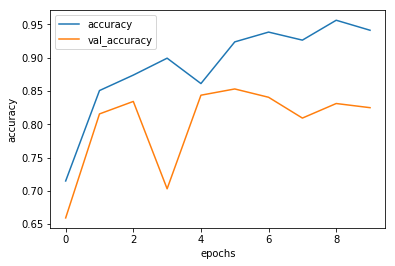

In [12]:
# 查看训练过程
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')

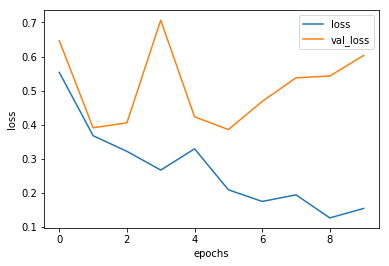

In [13]:
plot_graphs(history, 'loss')

In [14]:
test_loss, test_acc = model.evaluate(test_dataset)
print('test loss: ', test_loss)
print('test acc: ', test_acc)

391/391 [==============================] - 103s 262ms/step - loss: 0.6485 - accuracy: 0.8101
test loss:  0.6485284264282802
test acc:  0.81008


**上述模型不会mask掉序列的padding，所以如果在有padding的寻列上训练，测试没有padding的序列时可能有所偏差。**

In [15]:
def pad_to_size(vec, size):
    zeros = [0] * (size-len(vec))
    vec.extend(zeros)
    return vec

def sample_predict(sentence, pad=False):
    
    tokened_sent = tokenizer.encode(sentence)
    if pad:
        tokened_sent = pad_to_size(tokened_sent, 64)
    pred = model.predict(tf.expand_dims(tokened_sent, 0))
    return pred

In [16]:
# 没有padding的情况
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.58874863]]


In [17]:
# 有paddin的情况
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.8169492]]


## 堆叠更多的lstm层

In [18]:
from tensorflow.keras import layers
model = keras.Sequential(
[
    layers.Embedding(tokenizer.vocab_size, 64),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [19]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

In [20]:
history=model.fit(train_dataset, epochs=1, validation_data=test_dataset)

391/391 [==============================] - 1016s 3s/step - loss: 0.5524 - accuracy: 0.7158 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


In [22]:
res = model.evaluate(test_dataset)
print(res)

391/391 [==============================] - 188s 482ms/step - loss: 0.4812 - accuracy: 0.7880
[0.48124053586474463, 0.788]
